In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 28 Lecture 1 Assignment

In this assignment, we will learn about making predictions with linear models. We will use the king county housing dataset loaded below and analyze the regression from this dataset.

In [2]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.regressionplots import plot_leverage_resid2

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/kc_house_data.csv"
)

<IPython.core.display.Javascript object>

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<IPython.core.display.Javascript object>

We'll start by filtering out columns and keeping only: price, bedrooms, bathrooms, sqft_living, floors, and waterfront.

In [6]:
keep_cols = ["price", "bedrooms", "bathrooms", "sqft_living", "floors", "waterfront"]
df = df[keep_cols]
df.head(2)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
0,221900.0,3,1.00,1180,1.0,0
1,538000.0,3,2.25,2570,2.0,0


<IPython.core.display.Javascript object>

In [7]:
df.isna().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
floors         0
waterfront     0
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df.dtypes

price          float64
bedrooms         int64
bathrooms      float64
sqft_living      int64
floors         float64
waterfront       int64
dtype: object

<IPython.core.display.Javascript object>

In [9]:
df["waterfront"].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

<IPython.core.display.Javascript object>

Next create a pair plot in Seaborn to see the relationships between your features.

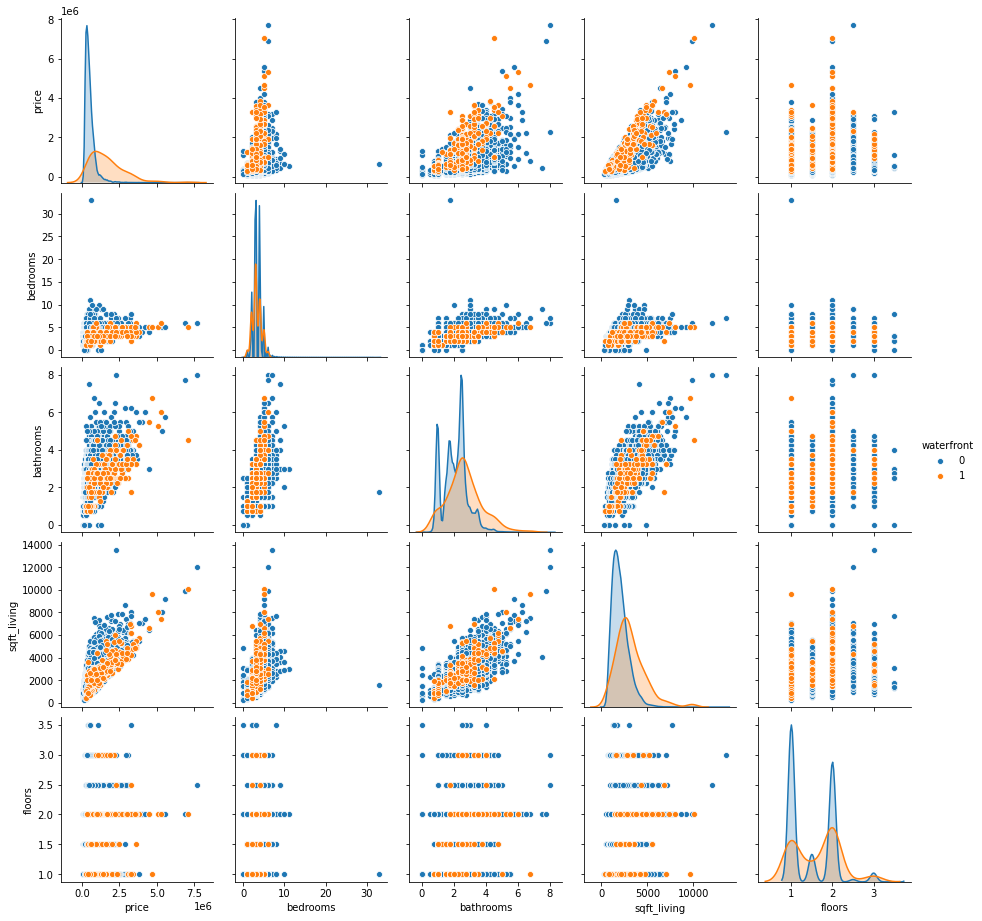

<IPython.core.display.Javascript object>

In [10]:
# Both bedrooms and sqft_living have pattern breaking outliers
# Many variables are right hand skewed
# Notably the price is right hand skewed, we might transform
sns.pairplot(df, hue="waterfront")
plt.show()

There are two noticeable outliers here that will cause problems. Remove them.

In [11]:
# 33 bedrooms but only 1620 sqft and $640K price
# likely a typo
df.sort_values("bedrooms", ascending=False).head(2)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
15870,640000.0,33,1.75,1620,1.0,0
8757,520000.0,11,3.00,3000,2.0,0


<IPython.core.display.Javascript object>

In [12]:
# 7.5 bathrooms but only 1620 sqft and $640K price
# likely a typo
df.sort_values("bathrooms", ascending=False).head(5)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
7252,7700000.0,6,8.00,12050,2.5,0
12777,2280000.0,7,8.00,13540,3.0,0
9254,6885000.0,6,7.75,9890,2.0,0
8546,450000.0,9,7.50,4050,2.0,0
8092,4668000.0,5,6.75,9640,1.0,1


<IPython.core.display.Javascript object>

In [13]:
# 13540 square feet but $2M price, most homes this size are wayyyy higher price
# might be a typo or a sale to family member
df.sort_values("sqft_living", ascending=False).head(2)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
12777,2280000.0,7,8.0,13540,3.0,0
7252,7700000.0,6,8.0,12050,2.5,0


<IPython.core.display.Javascript object>

In [14]:
# dropping by row name
df = df.drop([15870, 12777])

<IPython.core.display.Javascript object>

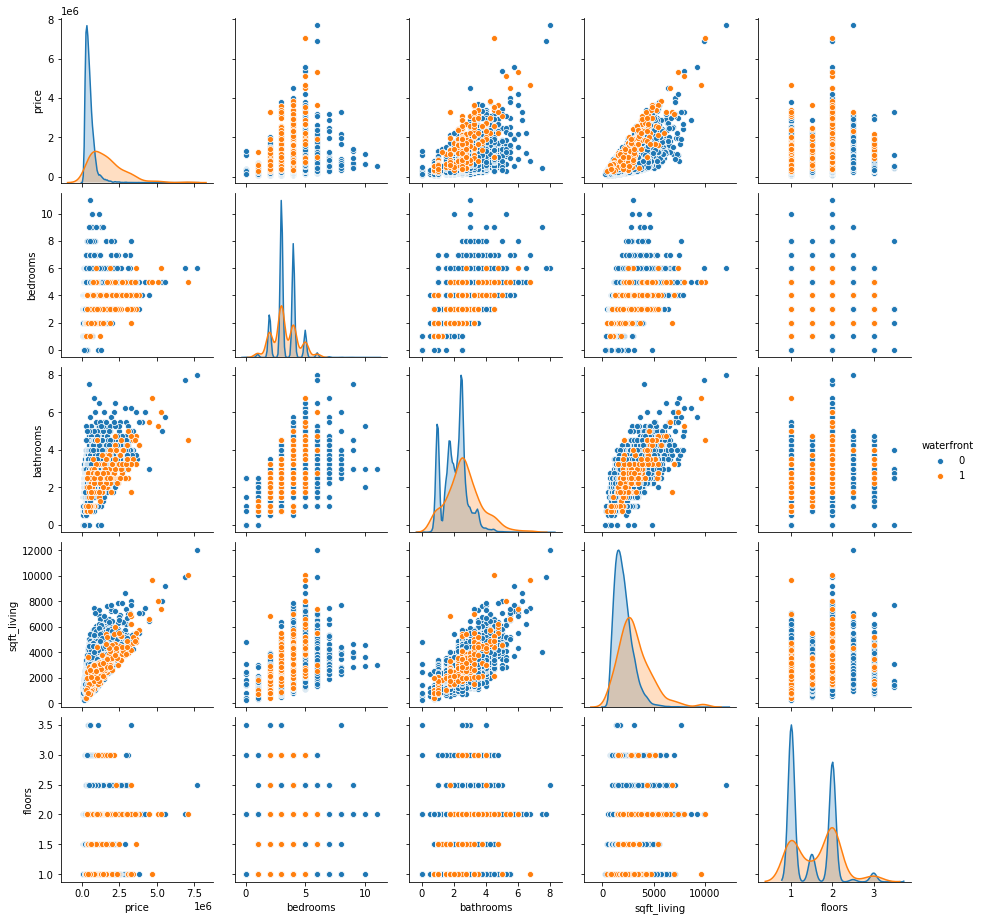

<IPython.core.display.Javascript object>

In [15]:
sns.pairplot(df, hue="waterfront")
plt.show()

Next, we'll check for missing values and remove rows containing missing values. We will also make sure that all our data is numeric and convert the columns that are of object type to numeric. Make sure to remove any rows with missing data resulting from the conversion to numeric.

In [16]:
# all good already

<IPython.core.display.Javascript object>

Split the data into test and train subsets. Use 20% of the data for the test subset. Use price as the dependent variable.

In [17]:
# Uses orignal inputs
X = df.drop(columns="price")
y = df["price"]

<IPython.core.display.Javascript object>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [19]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

<IPython.core.display.Javascript object>

Check the model assumptions: homoscedacity, normal errors, and multicollinearity

In [20]:
print_vif(X_train)

VIF results
-------------------------------
const          19.820710
bedrooms        1.607796
bathrooms       2.804379
sqft_living     2.635564
floors          1.361457
waterfront      1.017459
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [21]:
model = sm.OLS(y_train, X_train_const).fit()

<IPython.core.display.Javascript object>

In [22]:
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

0.0

<IPython.core.display.Javascript object>

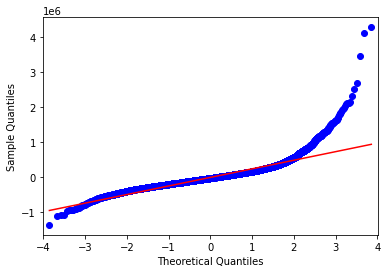

<IPython.core.display.Javascript object>

In [23]:
sm.qqplot(model.resid, line="s")
plt.show()

Create your final linear model and produce a model summary. Look at the coefficients and interpret their meaning. How do each of them influence the final prediction?

In [24]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4060.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:07:47   Log-Likelihood:            -2.3907e+05
No. Observations:               17288   AIC:                         4.782e+05
Df Residuals:                   17282   BIC:                         4.782e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         7.19e+04   8305.028      8.657      

<IPython.core.display.Javascript object>

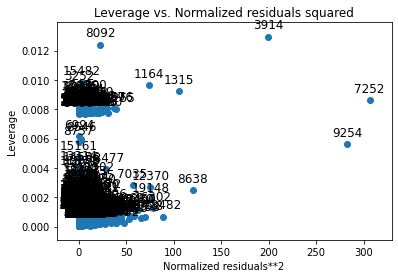

<IPython.core.display.Javascript object>

In [25]:
# Other extreme points we might consider dropping to improve fit
plot_leverage_resid2(model)
plt.show()

Predict the y values for the test sample using our model above.

Plot the true vs. predicted values and compute the MAE, MSE, RMSE and MAPE. How accurate is our model?

In [26]:
y_pred = model.predict(X_test_const)

<IPython.core.display.Javascript object>

In [27]:
# MAE: On average how far off are we?
np.mean(np.abs(y_pred - y_test))

171684.2820679654

<IPython.core.display.Javascript object>

In [28]:
# MAPE: On average how far off are we as a percentage?
np.mean(np.abs((y_pred - y_test) / y_test))

0.34680857713430024

<IPython.core.display.Javascript object>

In [29]:
# RMSE: think of similar to MAE with a bigger penalty for big mistakes
np.sqrt(np.mean((y_pred - y_test) ** 2))

259369.6818604865

<IPython.core.display.Javascript object>

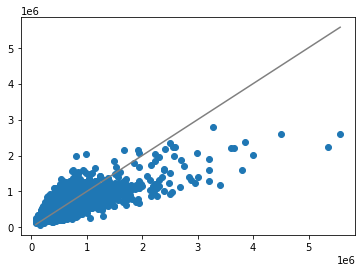

<IPython.core.display.Javascript object>

In [30]:
# The biggest mistakes are on the largest house prices, might consider a log transform
mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")
plt.show()

-----

What if we log transformed `y`?

In [31]:
# If we log transformed:
model = sm.OLS(np.log(y_train), X_train_const).fit()
model.rsquared

0.5029121081935028

<IPython.core.display.Javascript object>

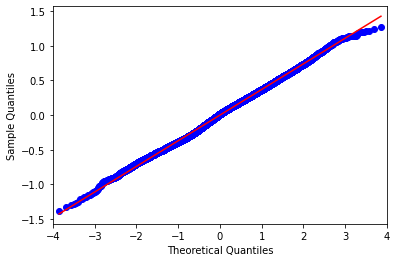

<IPython.core.display.Javascript object>

In [32]:
sm.qqplot(model.resid, line="s")
plt.show()

In [33]:
y_pred = model.predict(X_test_const)
y_pred = np.exp(y_pred)

<IPython.core.display.Javascript object>

In [34]:
# MAE: On average how far off are we?
np.mean(np.abs(y_pred - y_test))

164722.1980216561

<IPython.core.display.Javascript object>

In [35]:
# MAPE: On average how far off are we as a percentage?
np.mean(np.abs((y_pred - y_test) / y_test))

0.31424360649490224

<IPython.core.display.Javascript object>

In [36]:
# RMSE: think of similar to MAE with a bigger penalty for big mistakes
np.sqrt(np.mean((y_pred - y_test) ** 2))

263056.04105660523

<IPython.core.display.Javascript object>

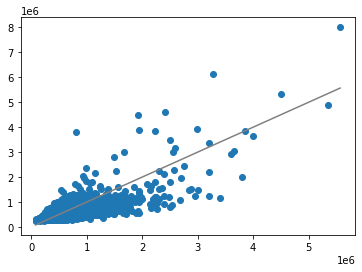

<IPython.core.display.Javascript object>

In [37]:
# The biggest mistakes are on the largest house prices, might consider a log transform
mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")
plt.show()

Log transform decreased R squared but improved every metric on the test set.  Make sure to not use $R^2$ as the only metric you view.